In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading the data

In [2]:
confirmed = pd.read_csv('./DATASETS/COVID-Time Series Data - Refined/confirmed.csv')

confirmed = confirmed.melt(['State', 'Country'], confirmed.columns[4:], var_name='Dates', value_name='Confirmed')
confirmed.Dates = pd.to_datetime(confirmed.Dates)

confirmed.head()

,State,Country,Dates,Confirmed
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


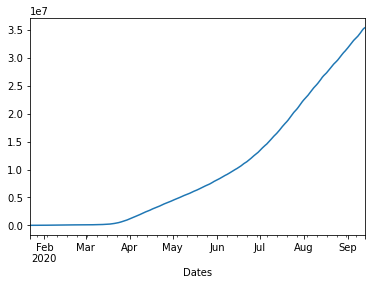

In [3]:
days = confirmed.groupby('Dates').sum()
days.Confirmed.resample('d').sum().plot();

In [4]:
days.head()

,Confirmed
Dates,
2020-01-22,556
2020-01-23,655
2020-01-24,943
2020-01-25,1436
2020-01-26,2123


In [5]:
days.tail()

,Confirmed
Dates,
2020-09-09,34222892
2020-09-10,34557534
2020-09-11,34924974
2020-09-12,35244068
2020-09-13,35422326


In [6]:
len(days)

236

# 2. Preparing the data for the LSTM model

In [7]:
# number of data in the test set
test_size = 30
test_ind = len(days) - test_size

train = days.iloc[:test_ind,:]
test = days.iloc[test_ind:,:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

# The data is scaled
scaler = MinMaxScaler(feature_range=(0,10))

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# batch size should be less than len(test)
BS = 15

generator = TimeseriesGenerator(scaled_train, scaled_train, length=BS, batch_size=1)

In [10]:
x1, y1 = generator[0]
x2, y2 = generator[1]

In [11]:
# given data of last BS days it will predict the expected number of cases for the (BS+1)th day

print(f'example 1: {x1}\n{y1}\n\n\nexample 2: {x2}\n{y2}')

example 1: [[[0.00000000e+00]
  [3.73286699e-05]
  [1.45921164e-04]
  [3.31810399e-04]
  [5.90848745e-04]
  [8.95888077e-04]
  [1.89546690e-03]
  [2.11717658e-03]
  [2.89693102e-03]
  [3.53566604e-03]
  [4.33238805e-03]
  [6.12303303e-03]
  [7.29304175e-03]
  [8.80541846e-03]
  [1.02174979e-02]]]
[[0.01140862]]


example 2: [[[3.73286699e-05]
  [1.45921164e-04]
  [3.31810399e-04]
  [5.90848745e-04]
  [8.95888077e-04]
  [1.89546690e-03]
  [2.11717658e-03]
  [2.89693102e-03]
  [3.53566604e-03]
  [4.33238805e-03]
  [6.12303303e-03]
  [7.29304175e-03]
  [8.80541846e-03]
  [1.02174979e-02]
  [1.14086219e-02]]]
[[0.01276339]]


In [12]:
valGenerator = TimeseriesGenerator(scaled_test, scaled_test, length=BS, batch_size=1)

# 3. Building and compiling the model

In [13]:
# part 1: Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.regularizers import l1

n_features = 1
model = Sequential()

# a. input layer
model.add(LSTM(58, activation=None, input_shape=(BS, n_features)))

# b. hidden layers
# model.add(Dense(18, activation='relu', kernel_regularizer=l1()))

# c. final layer
model.add(Dense(1))


# part 2: compiling the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='mse')

print(model.summary())

# part 3: training the model
EPOCHS = 10

# Without early stopping

"""

H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator)

"""

# With early stopping
# """

from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor='val_loss', patience=4)
H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator, callbacks=[earlyStop])


# """

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 58)                13920     
_________________________________________________________________
dense (Dense)                (None, 1)                 59        
Total params: 13,979
Trainable params: 13,979
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 5s 26ms/step - loss: 0.9327 - val_loss: 0.0894
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0092 - val_loss: 0.0031
Epoch 3/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0056 - val_loss: 0.0532
Epoch 4/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0043 - val_loss: 0.3602
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0043 - val_loss: 0.0222
Epoc

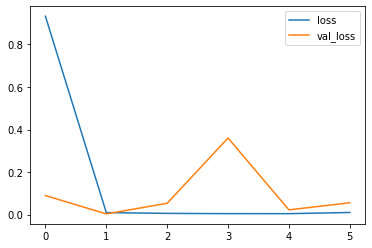

In [14]:
losses = pd.DataFrame(H.history)
losses.plot();

# 4. Evaluating the model

In [15]:
# last 12 rows from scaled_train
first_eval_batch = scaled_train[-BS:]
print(first_eval_batch)

[[ 8.3548765 ]
 [ 8.47157573]
 [ 8.57591652]
 [ 8.66921105]
 [ 8.78846899]
 [ 8.91065062]
 [ 9.04067468]
 [ 9.16852876]
 [ 9.28764266]
 [ 9.38989494]
 [ 9.49434885]
 [ 9.60808252]
 [ 9.7337444 ]
 [ 9.86099972]
 [10.        ]]


In [16]:
# array to store the forcasted results
test_predictions = []

current_batch = first_eval_batch.reshape((1, BS, n_features))

count=1

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[ 8.3548765 ]
  [ 8.47157573]
  [ 8.57591652]
  [ 8.66921105]
  [ 8.78846899]
  [ 8.91065062]
  [ 9.04067468]
  [ 9.16852876]
  [ 9.28764266]
  [ 9.38989494]
  [ 9.49434885]
  [ 9.60808252]
  [ 9.7337444 ]
  [ 9.86099972]
  [10.        ]]],
 prediction: [9.961192]



Result 2:
current batch:
[[[ 8.47157573]
  [ 8.57591652]
  [ 8.66921105]
  [ 8.78846899]
  [ 8.91065062]
  [ 9.04067468]
  [ 9.16852876]
  [ 9.28764266]
  [ 9.38989494]
  [ 9.49434885]
  [ 9.60808252]
  [ 9.7337444 ]
  [ 9.86099972]
  [10.        ]
  [ 9.96119213]]],
 prediction: [10.059388]



Result 3:
current batch:
[[[ 8.57591652]
  [ 8.66921105]
  [ 8.78846899]
  [ 8.91065062]
  [ 9.04067468]
  [ 9.16852876]
  [ 9.28764266]
  [ 9.38989494]
  [ 9.49434885]
  [ 9.60808252]
  [ 9.7337444 ]
  [ 9.86099972]
  [10.        ]
  [ 9.96119213]
  [10.05938816]]],
 prediction: [10.157206]



Result 4:
current batch:
[[[ 8.66921105]
  [ 8.78846899]
  [ 8.91065062]
  [ 9.04067468]
  [ 9.16852876]
  [ 9.28

In [17]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions)

[[26418802.99100399]
 [26679230.35060596]
 [26938653.59562874]
 [27192975.33156776]
 [27441226.85342598]
 [27683810.31288624]
 [27921767.76336575]
 [28155225.66765785]
 [28384750.57907677]
 [28610909.0509367 ]
 [28834308.10464573]
 [29055236.0753727 ]
 [29274034.41265965]
 [29491019.27348995]
 [29706605.45582581]
 [29920863.77883148]
 [30135220.74281597]
 [30347265.96693802]
 [30557105.67994404]
 [30764868.87388325]
 [30970712.3626194 ]
 [31174770.19671345]
 [31377085.37351513]
 [31577743.88772392]
 [31776776.09041023]
 [31974214.86190033]
 [32170065.26070595]
 [32364342.46236229]
 [32557021.17431068]
 [32748129.21836567]]


In [18]:
test['Predictions'] = true_predictions.astype(int)
test

C:\Users\Python\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Confirmed,Predictions
Dates,,
2020-08-15,26817991,26418802
2020-08-16,27072589,26679230
2020-08-17,27316796,26938653
2020-08-18,27618067,27192975
2020-08-19,27938036,27441226
2020-08-20,28249176,27683810
2020-08-21,28568520,27921767
2020-08-22,28878633,28155225
2020-08-23,29119151,28384750


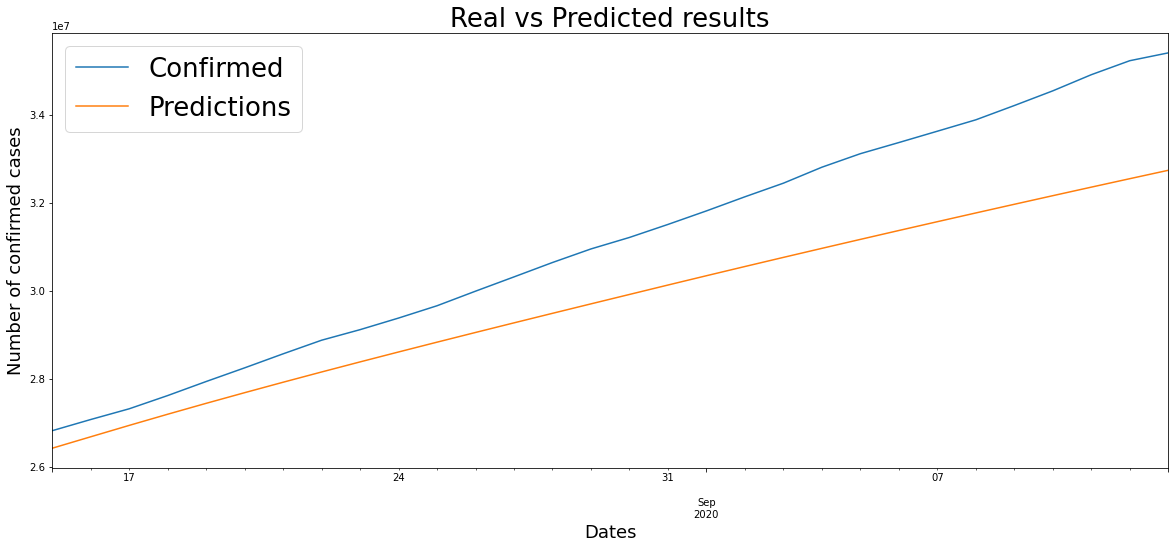

In [19]:
test.plot(figsize=(20,8));
plt.title('Real vs Predicted results', fontsize=26)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Number of confirmed cases', fontsize=18)
plt.legend(loc=2, prop={'size': 26})

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(test.Confirmed, test.Predictions)
length = len(test)
rmse = np.sqrt(mse/length)

r2s = r2_score(test.Confirmed, test.Predictions) 

print(f'RMSE = {rmse}; r2 score = {r2s}')

RMSE = 282186.6884355048; r2 score = 0.6483600272730377


# 5. Forecasting the number of confirmed cases for the next N days

In [21]:
from pandas.tseries.offsets import DateOffset

ndays=60
last_date = days.index[-1]
future_dates = [last_date+DateOffset(days=x) for x in range(1, ndays+1)]

In [22]:
days_copy = days.copy()
days_copy.tail()

,Confirmed
Dates,
2020-09-09,34222892
2020-09-10,34557534
2020-09-11,34924974
2020-09-12,35244068
2020-09-13,35422326


In [23]:
# get the scaled data for the last BS days in our dataset
last_index = len(days)
last_n_days = scaler.transform(days_copy.iloc[-BS:last_index,:])
last_n_days

array([[11.77119411],
       [11.88288375],
       [11.99906565],
       [12.12026619],
       [12.23713584],
       [12.37424028],
       [12.49038447],
       [12.58604126],
       [12.68338689],
       [12.78118386],
       [12.90378064],
       [13.02995984],
       [13.16850576],
       [13.28882248],
       [13.35603595]])

In [24]:
# array to store the forcasted results for the next ndays
test_predictions_ndays = []

current_batch = last_n_days.reshape((1, BS, n_features))

count=1

for i in range(ndays):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions_ndays.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[11.77119411]
  [11.88288375]
  [11.99906565]
  [12.12026619]
  [12.23713584]
  [12.37424028]
  [12.49038447]
  [12.58604126]
  [12.68338689]
  [12.78118386]
  [12.90378064]
  [13.02995984]
  [13.16850576]
  [13.28882248]
  [13.35603595]]],
 prediction: [13.214689]



Result 2:
current batch:
[[[11.88288375]
  [11.99906565]
  [12.12026619]
  [12.23713584]
  [12.37424028]
  [12.49038447]
  [12.58604126]
  [12.68338689]
  [12.78118386]
  [12.90378064]
  [13.02995984]
  [13.16850576]
  [13.28882248]
  [13.35603595]
  [13.21468925]]],
 prediction: [13.288915]



Result 3:
current batch:
[[[11.99906565]
  [12.12026619]
  [12.23713584]
  [12.37424028]
  [12.49038447]
  [12.58604126]
  [12.68338689]
  [12.78118386]
  [12.90378064]
  [13.02995984]
  [13.16850576]
  [13.28882248]
  [13.35603595]
  [13.21468925]
  [13.28891468]]],
 prediction: [13.365696]



Result 4:
current batch:
[[[12.12026619]
  [12.23713584]
  [12.37424028]
  [12.49038447]
  [12.58604126]
  [12.6

Result 30:
current batch:
[[[14.10473537]
  [14.16054535]
  [14.21585941]
  [14.27005863]
  [14.32321262]
  [14.37543106]
  [14.42681885]
  [14.4774704 ]
  [14.5274477 ]
  [14.57679367]
  [14.62552834]
  [14.67364979]
  [14.72113228]
  [14.7679491 ]
  [14.81406498]]],
 prediction: [14.859462]



Result 31:
current batch:
[[[14.16054535]
  [14.21585941]
  [14.27005863]
  [14.32321262]
  [14.37543106]
  [14.42681885]
  [14.4774704 ]
  [14.5274477 ]
  [14.57679367]
  [14.62552834]
  [14.67364979]
  [14.72113228]
  [14.7679491 ]
  [14.81406498]
  [14.85946178]]],
 prediction: [14.904134]



Result 32:
current batch:
[[[14.21585941]
  [14.27005863]
  [14.32321262]
  [14.37543106]
  [14.42681885]
  [14.4774704 ]
  [14.5274477 ]
  [14.57679367]
  [14.62552834]
  [14.67364979]
  [14.72113228]
  [14.7679491 ]
  [14.81406498]
  [14.85946178]
  [14.9041338 ]]],
 prediction: [14.948092]



Result 33:
current batch:
[[[14.27005863]
  [14.32321262]
  [14.37543106]
  [14.42681885]
  [14.4774704 ]
  [

Result 60:
current batch:
[[[15.45672226]
  [15.49109459]
  [15.52479458]
  [15.55784035]
  [15.59024048]
  [15.62199116]
  [15.65310192]
  [15.68357849]
  [15.71343136]
  [15.74265671]
  [15.77127266]
  [15.79928398]
  [15.82669353]
  [15.85351086]
  [15.87974453]]],
 prediction: [15.905403]





In [25]:
true_predictions_ndays = scaler.inverse_transform(test_predictions_ndays).astype(int)
future_dates_df = pd.DataFrame(index=future_dates[:],columns=days.columns, data=true_predictions_ndays)
future_df = pd.concat([days_copy,future_dates_df])

In [26]:
future_df.head()

,Confirmed
2020-01-22,556
2020-01-23,655
2020-01-24,943
2020-01-25,1436
2020-01-26,2123


In [27]:
future_df.tail()

,Confirmed
2020-11-08,41902105
2020-11-09,41974798
2020-11-10,42045921
2020-11-11,42115496
2020-11-12,42183546


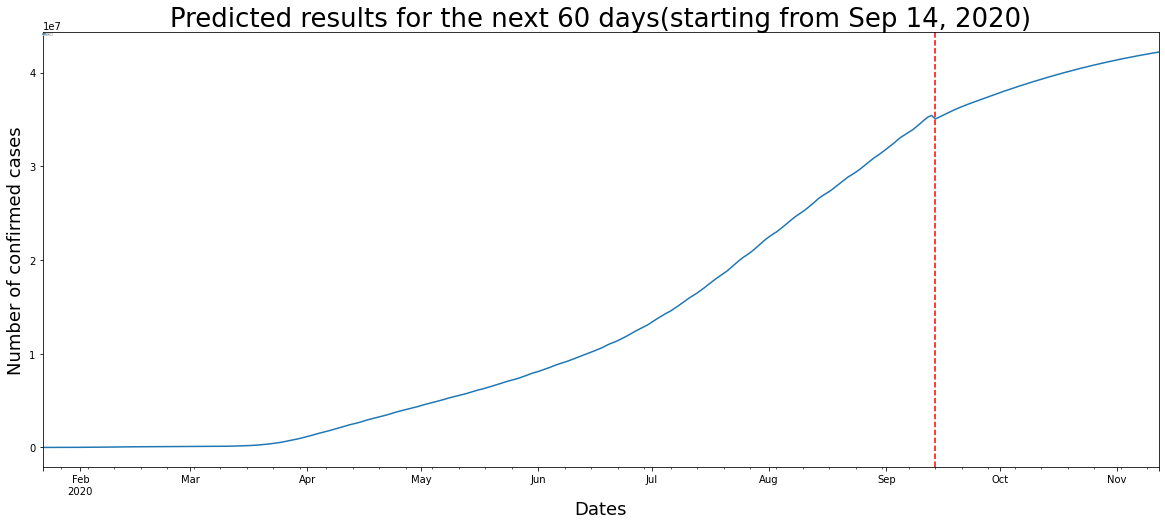

In [28]:
future_df.plot(figsize=(20,8));

plt.axvline("2020-09-14", color="red", linestyle="--");

plt.title(f'Predicted results for the next {ndays} days(starting from Sep 14, 2020)', fontsize=26);
plt.xlabel('Dates', fontsize=18);
plt.ylabel('Number of confirmed cases', fontsize=18);
plt.legend(loc=2, prop={'size': 0});